# NBA Player 2014-15 Stats

Let's explore some nba player stats:

- comparing two stat categories in a Q->Q scatter plots with best fit linear regression lines and correlation coefficients (also adding 3rd C dimension by labeling player positions)
- some C->Q comparisons of stats across guard / forward / center positions



In [1]:
import numpy as np
import csv

class Rows:
    """Helper class for dealing with small data sets read in by csv
    """
    def __init__(self, fname):
        with open(fname, 'r') as f:
            reader = csv.reader(f)
            self.colnames = next(reader)
            self.rows = list(reader)
            
    def col(self, *indices, conv=True):
        def col_val(c):
            if len(c) == 0:
                return None
            return float(c) if conv else c
        def row_val(row):
            v = [col_val(row[index]) for index in indices]
            return v
        return [row_val(row) for row in self.rows]

    def col_by_name(self, *colnames, conv=True):
        return self.col(*(self.colnames.index(colname) for colname in colnames), conv=conv)
    
    def clean_rows(self, *colnames, conv=True):
        """
        Returns rows filtering out any row where any column is missing.
        """
        row_vals = self.col_by_name(*colnames, conv=conv)
        clean_row_vals = (row_val for row_val in row_vals if all([c != None for c in row_val]))
        return clean_row_vals

player_stats = Rows('2014-15-player-per-game-averages.csv')

player_stats.colnames


['person_id',
 'last_name',
 'first_name',
 'position',
 'height_inches',
 'weight_lbs',
 'min',
 'pts',
 'fg_pct',
 'reb',
 'ast',
 'blk',
 'stl']

In [2]:
player_stats.col_by_name('pts')[:10]

[[5.9], [7.7], [13.3], [6.5], [2.3], [5.5], [23.4], [5.0], [8.6], [5.6]]

In [3]:
player_stats.col_by_name('height_inches')[:10]

[[79.0],
 [84.0],
 [77.0],
 [86.0],
 [82.0],
 [83.0],
 [83.0],
 [81.0],
 [76.0],
 [81.0]]

Would be fun to scatter plot different dimensions against each other, e.g to see whether there's a clear relationship between height and rebounds per game. Let's build a helper function to plot.

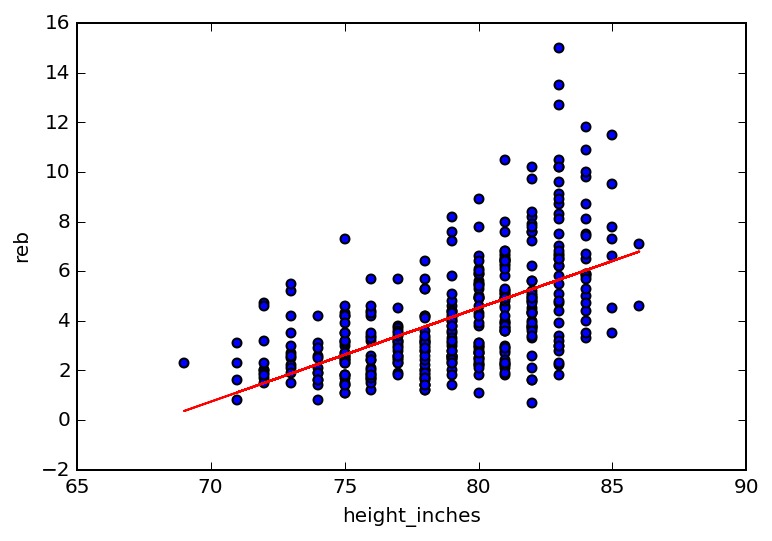

0.55233573948407055

In [4]:
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def plot(rows, x_col_name, y_col_name):
    x_vals, y_vals = zip(*rows.clean_rows(x_col_name, y_col_name))
    plt.scatter(x_vals, y_vals)
    plt.xlabel(x_col_name)
    plt.ylabel(y_col_name)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, y_vals)
    y_predicted = [intercept + slope*x for x in x_vals]
    plt.plot(x_vals, y_predicted, 'k-', color='red')
    plt.show()
    return r_value

r_value = plot(player_stats, 'height_inches', 'reb')

r_value

So rebounding is weakly correlated with height. What about weight?

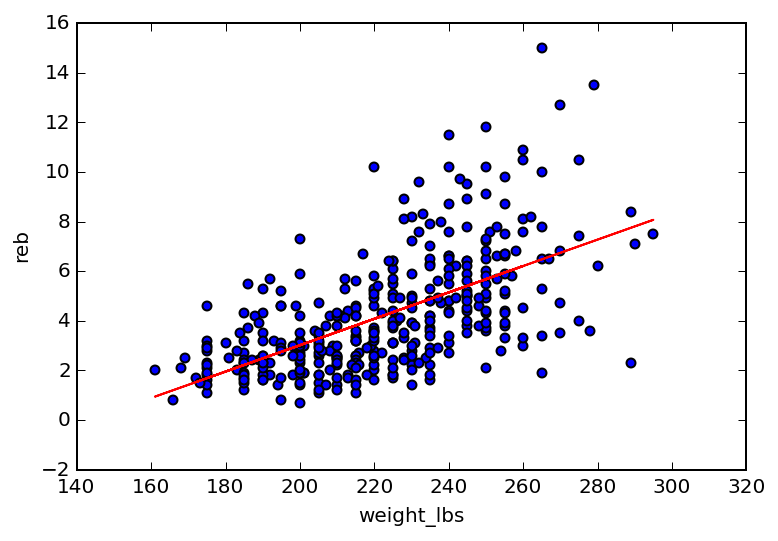

0.59750128866536678

In [5]:
r_value = plot(player_stats, 'weight_lbs', 'reb')

r_value

A little bit more predictive. Let's look at some more relationships for fun.

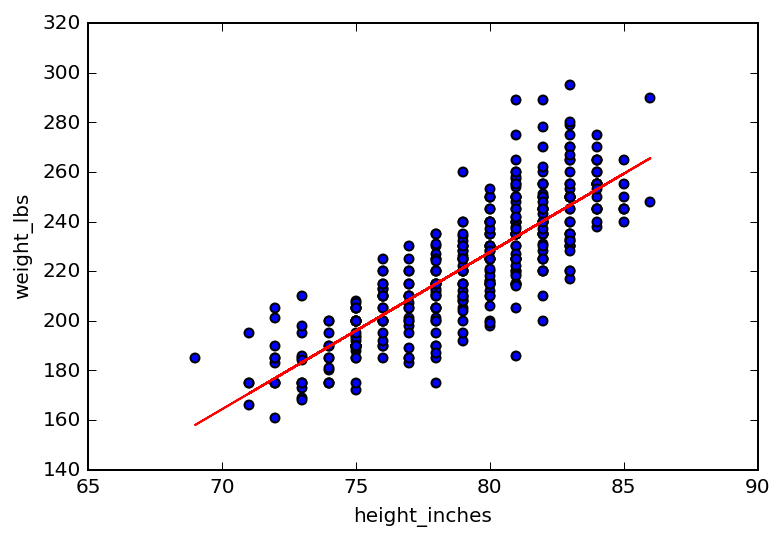

0.82325617366095505

In [6]:
r_value = plot(player_stats, 'height_inches', 'weight_lbs')
r_value

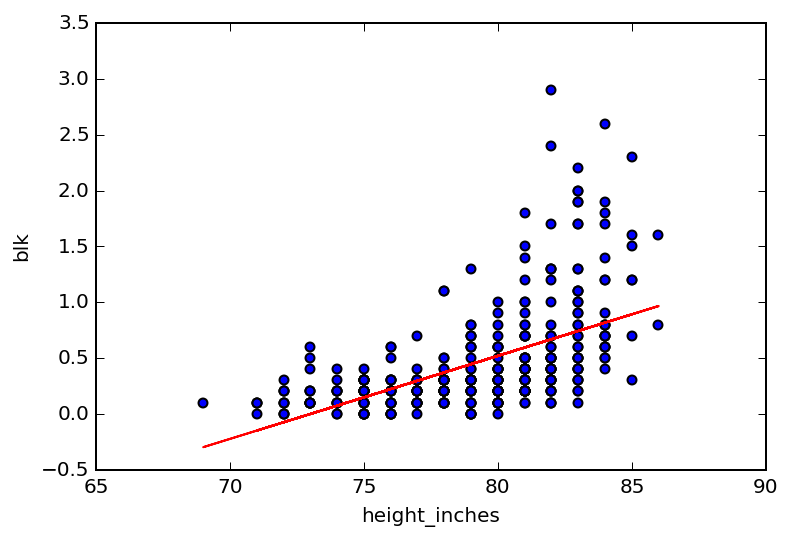

0.54387765386491582

In [7]:
plot(player_stats, 'height_inches', 'blk')


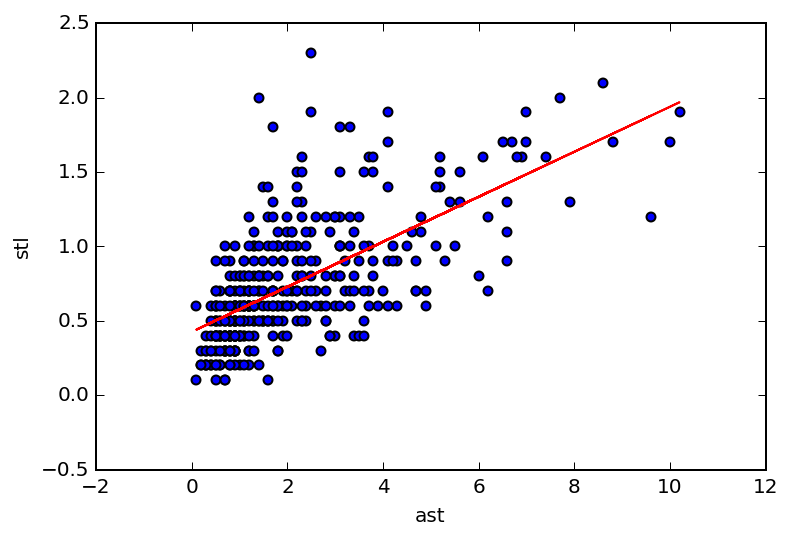

0.65664317495189883

In [8]:
plot(player_stats, 'ast', 'stl')

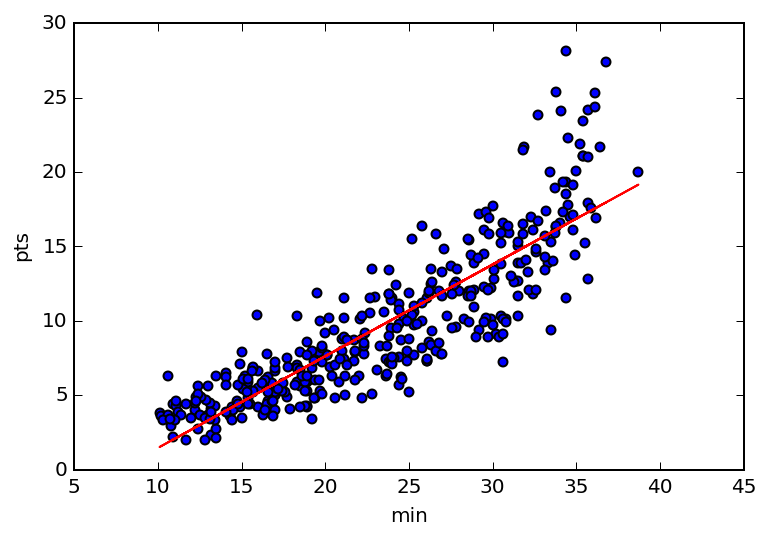

0.86582085304162326

In [9]:
plot(player_stats, 'min', 'pts')


Weight is very correlated with height: makes sense as most NBA dudes are ripped and lean.

Let's look at some pairings I wouldn't expect to have much correlation.

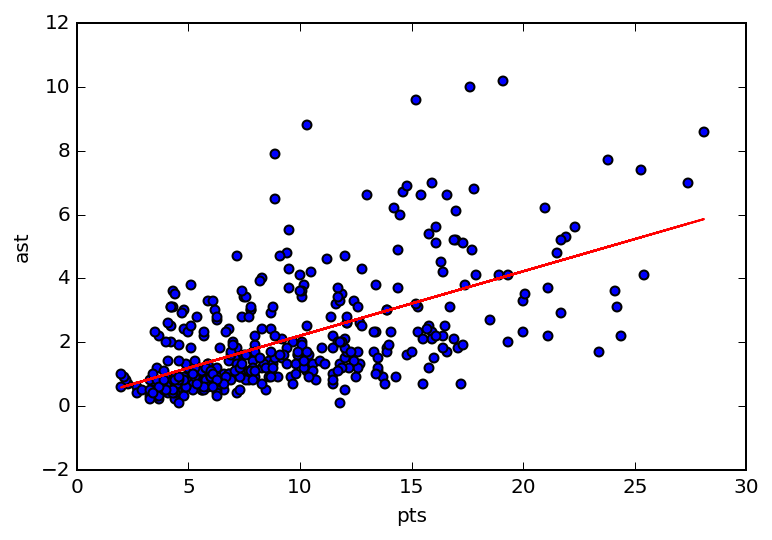

0.58579703010440354

In [10]:
plot(player_stats, 'pts', 'ast')

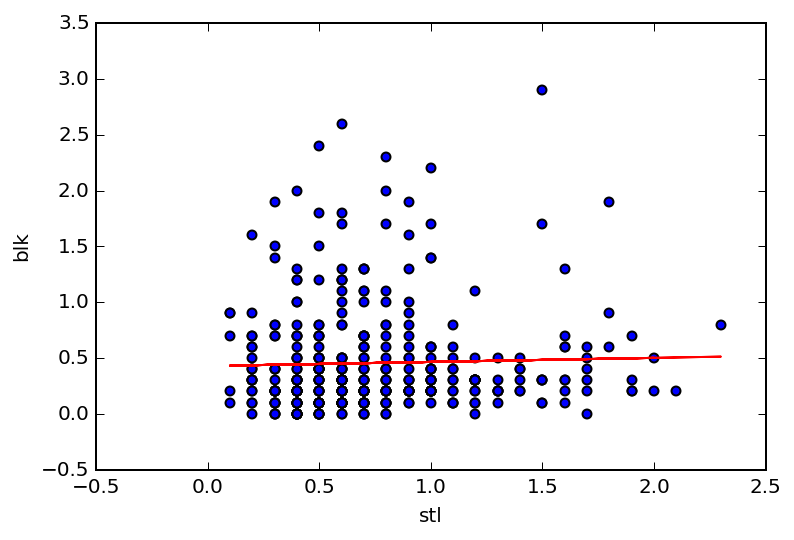

0.031807556410803559

In [11]:
plot(player_stats, 'stl', 'blk')

Finally, let's take a look at some of these where we label the points by position; I bet we'll see a tighter fit within particular positions.

In [12]:
set([r[0] for r in player_stats.clean_rows('position', conv=False)])

{'Center', 'Forward', 'Guard'}

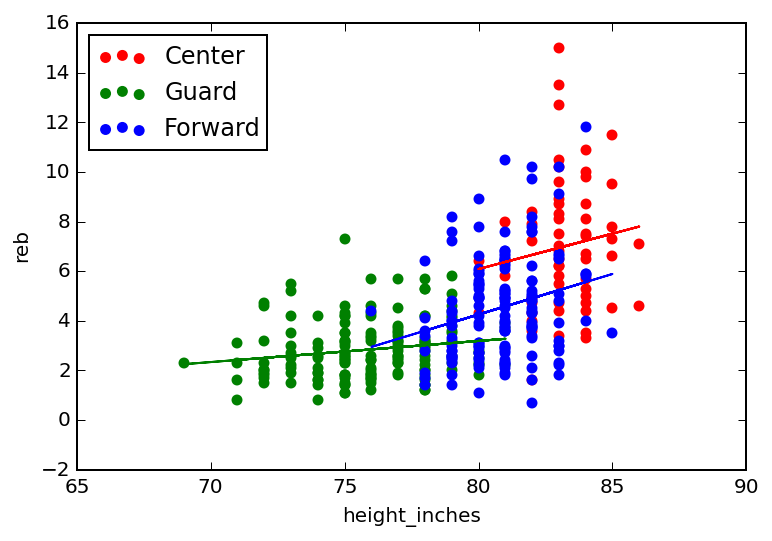

[('Center', 0.13303221752610414),
 ('Guard', 0.17422612413174524),
 ('Forward', 0.2399524539801445)]

In [13]:
import collections

def plot_with_pos(rows, x_col_name, y_col_name):
    by_pos = collections.defaultdict(list)
    for pos, x, y in rows.clean_rows('position', x_col_name, y_col_name, conv=False):
        by_pos[pos].append((float(x), float(y)))

    r_values = []
    for color, (pos, values) in zip(('red', 'green', 'blue'), by_pos.items()):
        x_vals, y_vals = zip(*values)
        plt.scatter(x_vals, y_vals, color=color, label=pos)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, y_vals)
        y_predicted = [intercept + slope*x for x in x_vals]
        plt.plot(x_vals, y_predicted, 'k-', color=color)
        r_values.append((pos, r_value))
        
    plt.xlabel(x_col_name)
    plt.ylabel(y_col_name)
    plt.legend(loc='upper left')
    plt.show()
    return r_values

plot_with_pos(player_stats, 'height_inches', 'reb')


Interesting, so once you break it down by position, the correlation between height and rebounding dissappears; being a tall guard apparently isn't really going to help you on the rebounding front. Or perhaps more likely, once you are tall, you are unlikely to be a guard.

Let's check out a few more.

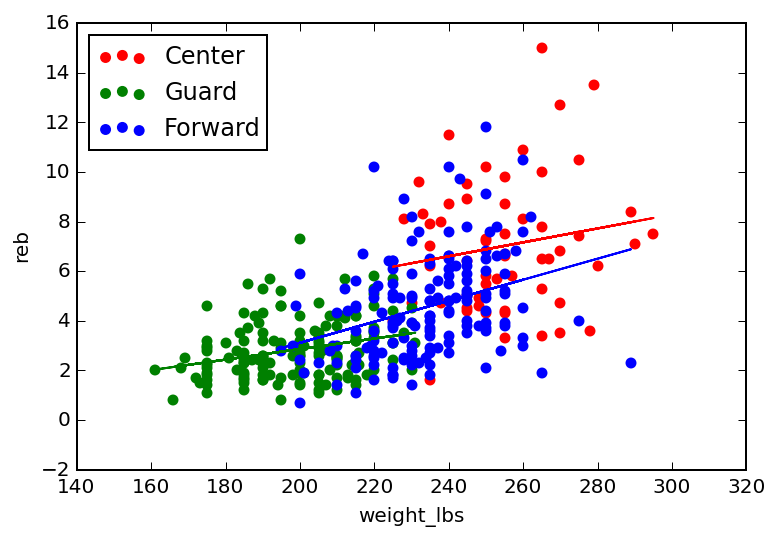

[('Center', 0.169264457788738),
 ('Guard', 0.28214386602193664),
 ('Forward', 0.33482761191805177)]

In [14]:
plot_with_pos(player_stats, 'weight_lbs', 'reb')

In [15]:
# reminding myself of the stats available
player_stats.colnames

['person_id',
 'last_name',
 'first_name',
 'position',
 'height_inches',
 'weight_lbs',
 'min',
 'pts',
 'fg_pct',
 'reb',
 'ast',
 'blk',
 'stl']

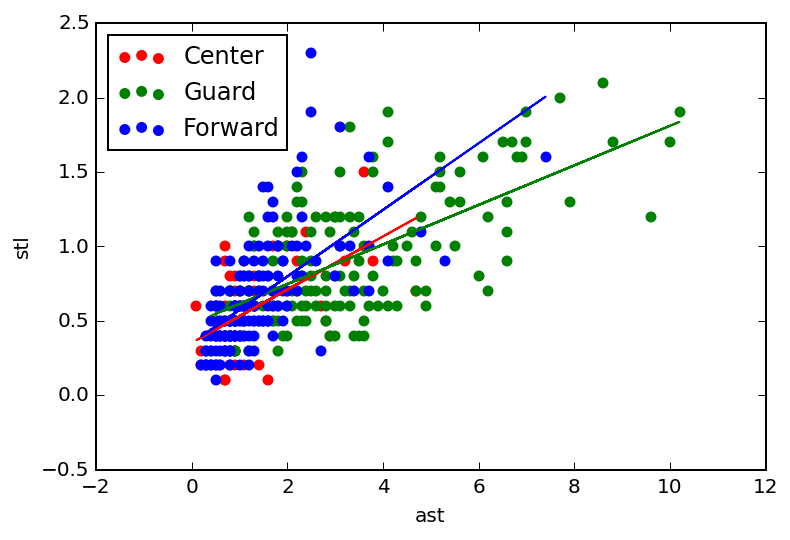

[('Center', 0.50013837907370517),
 ('Guard', 0.65501940965378647),
 ('Forward', 0.6066604618930902)]

In [16]:
plot_with_pos(player_stats, 'ast', 'stl')

The correlation of assists and steals is one of the few that actually holds up when you drill in across positions.

Let's end with come C->Q comparisions by looking at single stats across positions with side-by-side box plots.

In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

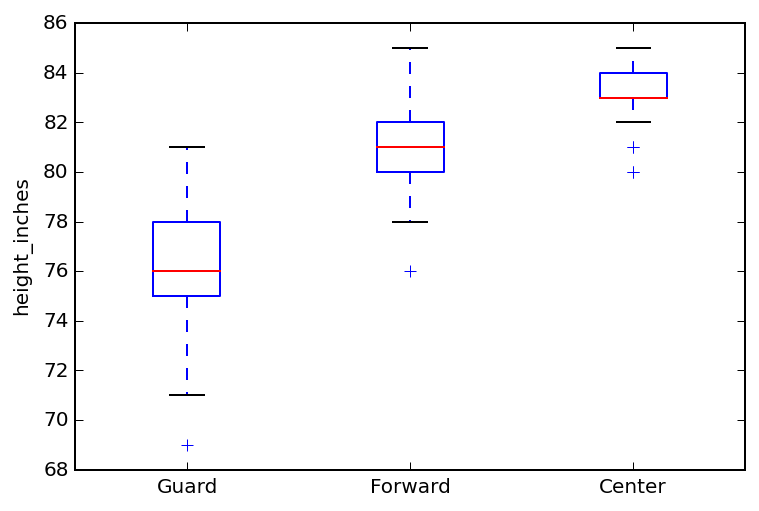

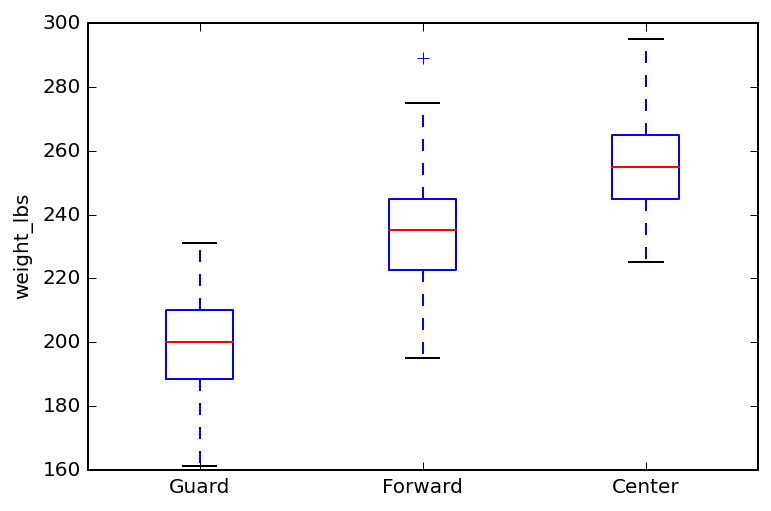

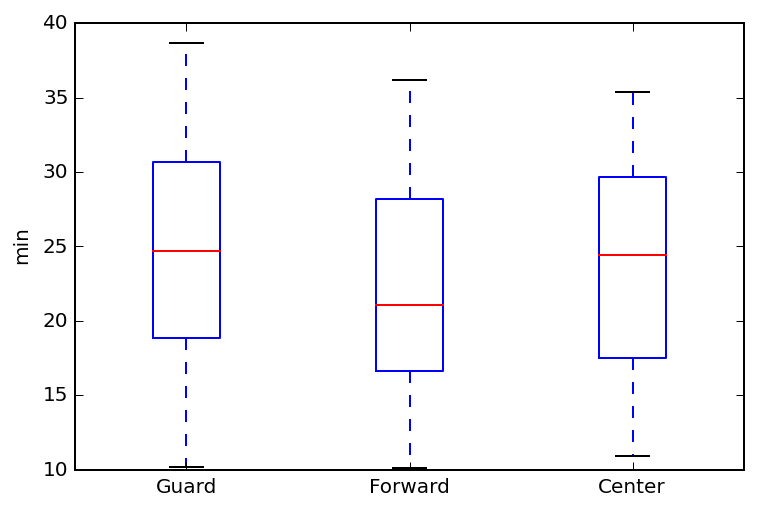

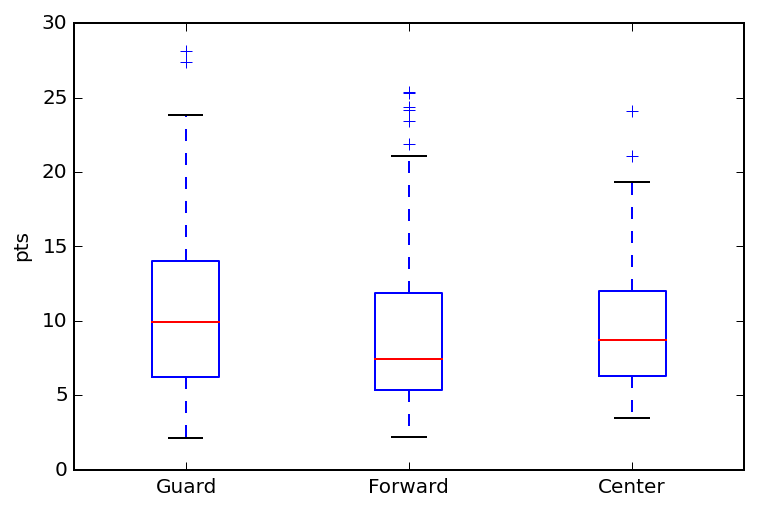

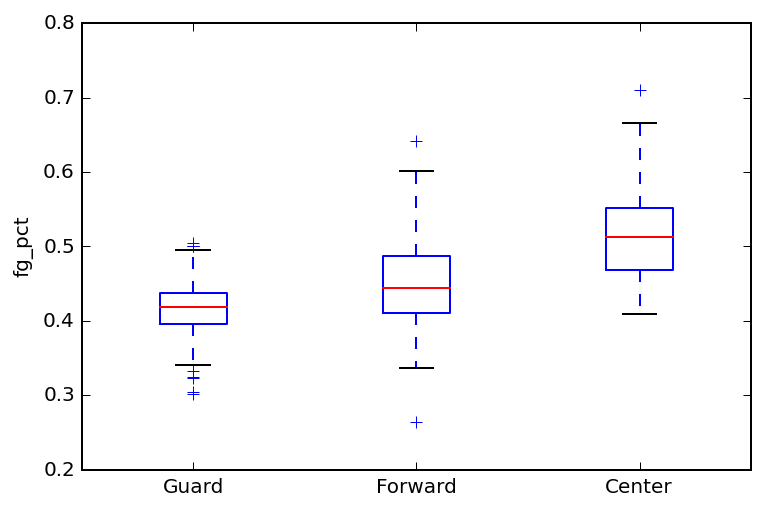

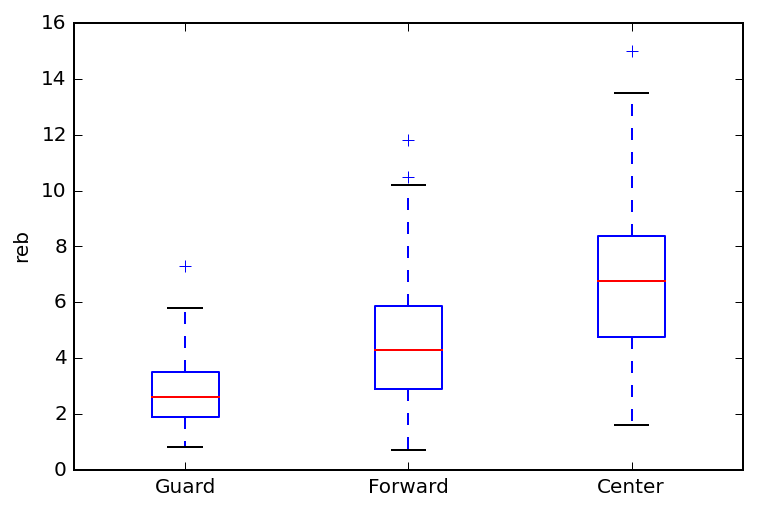

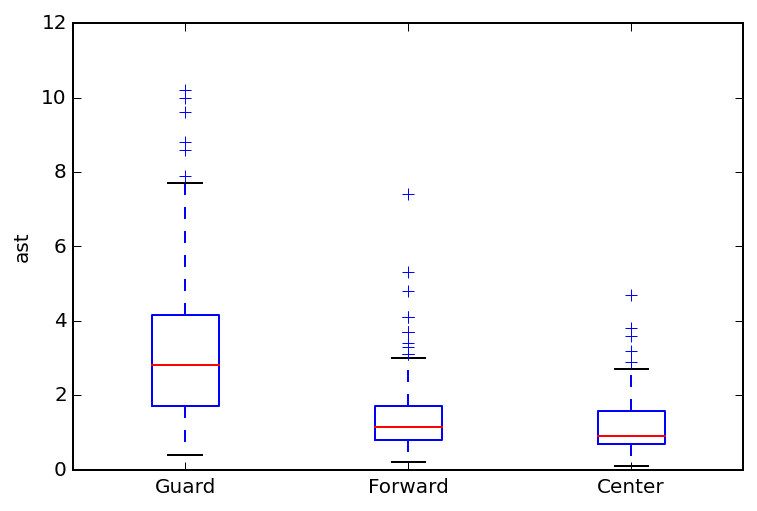

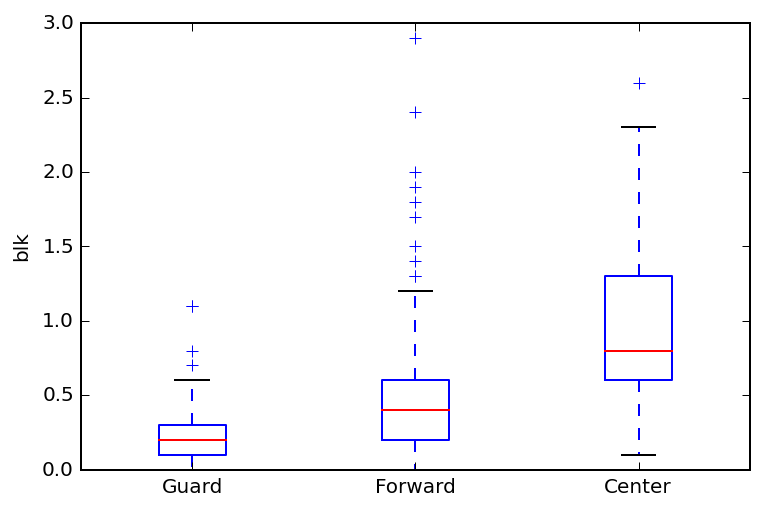

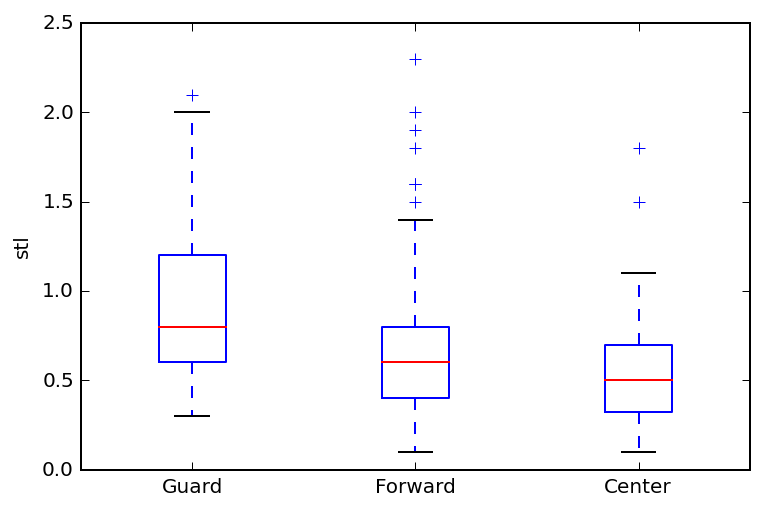

In [19]:
def box_plot_by_pos(rows, col_name):
    by_pos = collections.defaultdict(list)
    for pos, val in rows.clean_rows('position', col_name, conv=False):
        by_pos[pos].append(float(val))
    plt.figure()
    plt.ylabel(col_name)
    pos_in_order = ['Guard', 'Forward', 'Center'] # plot looks better in this order (smallest to largest pos)
    plt.boxplot([by_pos[pos] for pos in pos_in_order], labels=pos_in_order)
    plt.show()
    
for el in ['height_inches', 'weight_lbs', 'min', 'pts', 'fg_pct', 'reb', 'ast', 'blk', 'stl']:
    box_plot_by_pos(player_stats, el)